# Clust default normalization

1. Take median between replicates
2. Default normalization: quantile normalization -> log2 transformation -> z-score normalization

## Quantile normalization

Is a global, i.e., sample-wise, normalization technique aimed at removing technical variation between samples. It is based on the assumption that the distribution of expression values is similar across all samples. The method consists of the following steps: (1) sort the expression values for each gene in each sample; (2) compute the average expression value for each gene across samples; (3) replace the expression values for each gene in each sample with the average expression value for that gene across samples.

However, when the differences in the global distribution of expression values across samples is due to biological variation, quantile normalization is not a good idea, since it will remove biological variation.

Transcript / Cell - transform data shows large variation in the distribution of expression values across samples. Not sure this is due to biological variation or due to an artifact of the transformation.

In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from dokdonia import differentialexpression as DE
from dokdonia import visualization as VI
from dokdonia import clusteranalysis as CA
from dokdonia.pathway import KEGGPathwayParser, GenomeGBK, add_pathways_to_deseq_df

%matplotlib inline


root_dir = Path(os.getcwd())
results_dir = root_dir / "results"
data_dir = root_dir / "data"

In [53]:
def plot_density(df, ax=None, show_plot=True, title=None, show_legend=False):
    sns.set(style="whitegrid")
    if ax is None:
        fig, ax = plt.subplots()

    qn_df = quantile_normalize(df)
    qn_sample = qn_df.iloc[:, 0]

    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            sns.kdeplot(df[column], label=column, ax=ax, alpha=1)

    sns.kdeplot(qn_sample, label='Quantile Normalized', ax=ax, alpha=0.5, color='black', lw=2.5)
    if show_legend:
        ax.legend()
    ax.set_xlabel('Gene Expression Values')
    ax.set_ylabel('Density')
    if title is not None:
        ax.set_title(title)
    if show_plot:
        plt.show()
    return ax


def take_average_values(df, method="median"):
    index_name = df.index.name
    df_long = df.reset_index().melt(id_vars=index_name, var_name='Column', value_name='Value')
    df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
    df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])

    if method == "mean":
        aggregated_values = df_long.groupby([index_name, 'Temperature'])['Value'].mean().reset_index()
    elif method == "median":
        aggregated_values = df_long.groupby([index_name, 'Temperature'])['Value'].median().reset_index()
    else:
        raise ValueError("Invalid method. Please use 'mean' or 'median'.")

    return aggregated_values.pivot_table(index=index_name, columns='Temperature', values='Value')


def z_normalize(df):
    return df.apply(lambda x: (x - x.mean()) / x.std(ddof=0), axis=1)


def log2_normalize(df):
    return df.applymap(np.log2)


def quantile_normalize(df):
    rank_mean = df.stack().groupby(df.rank(method='first').stack().astype(int)).mean()
    return df.rank(method='min').stack().astype(int).map(rank_mean).unstack()

## Load counts

In [6]:
min_count = 10

counts = pd.read_csv(data_dir / 'DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)

## Load Transcript / Cell

In [18]:
# Get transcript/cell dataset
TC = pd.read_csv(data_dir / 'Dokdonia_transcripts_cell.csv', index_col=0)
TC = TC[TC.filter(regex='^[^T]+$').columns] # remove technical replicates
TC = TC.dropna(axis=1) # Remove L_18_R4 and D_18_R4 which did no have internal standards
TC = TC.set_index('index')
TC.index.name = 'ID'

TC_no18 = TC.drop(columns=[col for col in TC.columns if 'D_18' in col])
TC_avg = take_average_values(TC, method="median")
TC_no18_avg = take_average_values(TC_no18, method="median")

## Get DeSeq2 normalized counts

In [26]:
# Deseq2 normalization
colfactor = pd.DataFrame(
    {'Sample': counts.columns, 'Temperature': counts.columns.str.extract(r'_(\d+)_', expand=False)}
    ).iloc[1:, :].set_index('Sample', inplace=False)
colfactor.head()

deseq2_counts = DE.deseq2Normalize(counts, colfactor,
                gene_column="index",
                design_formula="~ Temperature")

INFO:DESeq2:Normalizing counts


## Get TPM values

In [23]:
# TPM-normalize count data
patric_file = pd.read_csv(data_dir / "Function_Annotations/PATRIC/Dokdonia_MED134_Craig_PATRIC_genome_feature.csv")
tpm = DE.tpmNormalize(counts, patric_file).set_index("index")

# Compare distributions

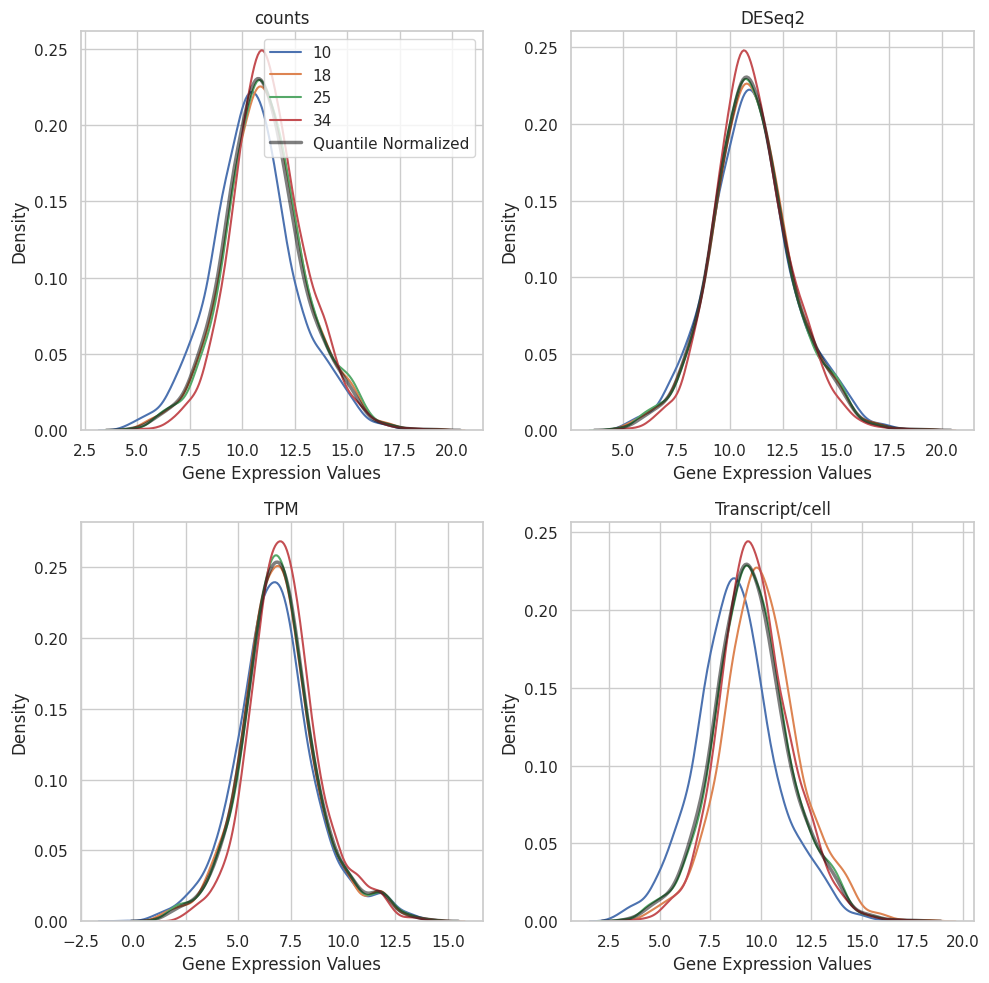

In [54]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

plot_density(log2_normalize(take_average_values(counts.set_index("index"))), ax=axs[0, 0], show_plot=False, title="counts", show_legend=True)
plot_density(log2_normalize(take_average_values(deseq2_counts.set_index("index"))), ax=axs[0, 1], show_plot=False, title="DESeq2")
plot_density(log2_normalize(take_average_values(tpm)), ax=axs[1, 0], show_plot=False, title="TPM")
plot_density(log2_normalize(take_average_values(1e4 * TC)), ax=axs[1, 1], show_plot=False, title="Transcript/cell")

plt.tight_layout()
plt.show()

In transcript / cell data, the distribution of expression values is quite different between samples. This is not the case for the DeSeq2 normalized counts or TPM values. Particularly, samples at 10º show lower expression values than the average, and samples at 18º higher expression values than the average. Thus, this variation is introduced by the transcript / cell transformation.

This observation also explains why the pattern showed in the clustering of transcript / cell data breaks down when quantile normalization is reversed.

# Clust removes one gene prior to clustering


Additionally, clust removes one gene: MED134_00230 before clustering. This gene shows the largest transript / cell values across temperatures.

In [3]:
input_data = pd.read_csv(
    "/home/robaina/Documents/Aquifex/Dokdonia/results/clust/CLUSTER_ONLY_TEMP_DE_GENES_TRANSCRIPT_CELL/Input_files_and_params/Data/clust_input.tsv", sep="\t", index_col=0
    )

processed_data = pd.read_csv(
    "/home/robaina/Documents/Aquifex/Dokdonia/results/clust/CLUSTER_ONLY_TEMP_DE_GENES_TRANSCRIPT_CELL/Processed_Data/clust_input.tsv_processed.tsv", sep="\t", index_col=0
    )

In [5]:
set(input_data.index) - set(processed_data.index)

{'MED134_00230'}

<AxesSubplot: xlabel='Temperature'>

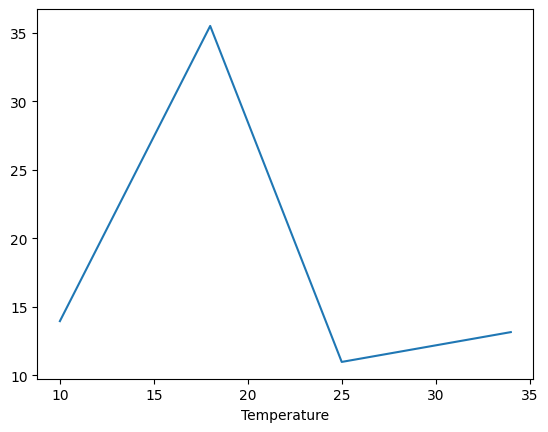

In [18]:
TC_avg.loc["MED134_00230",:].plot()

## Conclusions


1. Transcript / cell introduces biases at 10 and 18 degrees. Are these true biological variation or due to experimental error?

2. Clust removes one gene prior to clustering. This gene shows the largest transript / cell values across temperatures.

3. Clust default normalization is quantile normalization -> log2 transformation -> z-score normalization

4. Either we create new clusters without quantile normalization with transcript / cell data (different clusters) or assume that some clusters show no correspondance between pre and post quantile normalization or between deseq2 data and transcript / cell data.


## Some bibliography 

1. https://uclouvain-cbio.github.io/WSBIM1322/sec-norm.html
2. https://www.biorxiv.org/content/10.1101/012203v1.full